# Quasi-symmetry-protected BIC metasurface design

We demonstrate a quasi-symmetry-protected BIC metasurface design using two tilted ellipse meta-atoms.

## 0. Prepare

In [8]:
import importlib.util
# import lumapi
spec = importlib.util.spec_from_file_location('lumapi', 'D:\\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import c

In [ ]:
# import custom modules
sys.path.append("../module")
from MetaTool import setResources, addMaterialNK, getMatrixCenter

## 1. Constants, classes and functions

### 1.1 Constants

In [11]:
# color bar setting
cmap_amp = "Reds"  # amplitude use
cmap_ang = "RdBu_r"  # angle (phase) use

### 1.2 Classes

### 1.3 Functions

In [12]:
def fano(omega, omega_0, q, gamma, i_0, i_bg):
    """ 
    Fano formula
    @param omega: angular frequency [rad/s]
    @param omega_0: resonance angular frequency [rad/s]
    @param q: Fano asymmetry parameter
    @param gamma: line width [rad/s]
    @param i_0: scaling factor for intensity
    @param i_bg: background intensity
    @return: Fano function value
    """
    epsilon = (omega - omega_0) / (gamma / 2)
    return i_0 / (1 + q ** 2) * (q + epsilon) ** 2 / (1 + epsilon ** 2) + i_bg

## 2. High-Q-factor metasurface unit governed by symmetry-protected BIC

### 2.1 Parameter

In [ ]:
# parameters
# control parameters
hide = False  # whether to hide GUI or not

# unit parameters
unit_size = 1320e-9  # unit size [m]
unit_size_x = unit_size  # unit size along x direction [m]
unit_size_y = unit_size  # unit size along y direction [m]
units_rows = 1
units_cols = 1
# atom parameters
length = 220e-9  # length of ellipses along x axis [m]
width = 660e-9  # width of ellipses along y axis [m]
height = 200e-9  # height of atoms [m]
rotation_angle = np.deg2rad(0)  # initial asymmetric rotation angle [rad]
alpha = np.sin(rotation_angle)  # initial asymmetric parameter
rotation_angle_min = np.deg2rad(0)  # minimum rotation angle [rad]
rotation_angle_max = np.deg2rad(24)  # maximum rotation angle [rad]
rotation_angle_step = np.deg2rad(2)  # rotation angle step [rad]
rotation_angle_vec = np.linspace(rotation_angle_min, rotation_angle_max, 
                                    round((rotation_angle_max - rotation_angle_min) / rotation_angle_step + 1))
alpha_vec = np.sin(rotation_angle_vec)  # asymmetry parameter vector

# spectrum parameter
wavelength_min = 1480e-9  # minimum wavelength [m]
wavelength_max = 1650e-9  # maximum wavelength [m]
wavelength_number = 128  # wavelength sampling number
wavelength_vec = c / np.linspace(c / wavelength_max, c / wavelength_min, wavelength_number)

# material parameters
material_atom = "X"  # material of atom
material_substrate = "etch"  # material of substrate
if material_atom == "X":
    n = 3.77  # refractive index of cylinder material
    k = 0  # imaginary refractive index

separation = wavelength_max / 2  # safe spacing between the objects and simulation boundaries
sep_ub_t = separation  # spacing between upper bound and transmission plane
sep_t_atom = separation  # spacing between transmission plane and atom
sep_interface_source = separation * 0.5  # spacing between interface (atom / substrate) and source
sep_source_r = separation  # spacing between source and reflection plane
sep_r_lb = separation  # spacing between reflection plane and lower bound
height_substrate = separation * 4  # height of substrate

# simulation size
sim_x_span = unit_size_x * units_cols
sim_y_span = unit_size_y * units_rows

# boundary conditions: PML / Period / Bloch / (Anti-)Symmetric
boundary_x_min = "Period"
boundary_x_max = "Period"
boundary_y_min = "Period"
boundary_y_max = "Period"
boundary_z_min = "PML"
boundary_z_max = "PML"

# mesh settings
# automate un-uniform x, y, and z
mesh_accuracy = 2

### 2.2 Simulation

In [14]:
# open fdtd
fdtd = lumapi.FDTD(hide=hide)
print(">> Progress: FDTD is opened.")

>> Progress: FDTD is opened.


In [16]:
if material_atom == "X":
    addMaterialNK(fdtd, "X", n=n, k=k)

In [17]:
# resource settings
parallel_job_number = 2
processes = 1
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [18]:
# define basic objects
# make sure in layout mode
if fdtd.layoutmode() != 1:  # layoutmode() return 0 when in analysis mode
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects

# source
source = fdtd.addplane(
    name="source",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    polarization_angle=0,
    # phase
    phase=0,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)

# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z_min=-(sep_interface_source + sep_source_r + sep_r_lb),
    z_max=height + sep_t_atom + sep_ub_t,
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy,
)

# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="power profile T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=height + sep_t_atom,
)
power_profile_r = fdtd.addpower(
    name="power profile R",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=-(sep_interface_source + sep_source_r),
)

# substrate
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=-height_substrate,
    material=material_substrate
)
atom_left = fdtd.addcircle(
    name="atom left",
    x=-unit_size_x / 4,
    y=0.0,
    z_min=0.0,
    z_max=height,
    make_ellipsoid=1,
    radius=length / 2,
    radius_2=width / 2,
    material="X",
    first_axis="z",
    rotation_1=np.rad2deg(-rotation_angle)
)
atom_right = fdtd.addcircle(
    name="atom right",
    x=unit_size_x / 4,
    y=0.0,
    z_min=0.0,
    z_max=height,
    make_ellipsoid=1,
    radius=length / 2,
    radius_2=width / 2,
    material="X",
    first_axis="z",
    rotation_1=np.rad2deg(rotation_angle)
)

In [ ]:
# define variables for storing the results
t_mat = np.zeros((len(alpha_vec), len(wavelength_vec)))
r_mat = np.zeros((len(alpha_vec), len(wavelength_vec)))
phase_t_mat = np.zeros((len(alpha_vec), len(wavelength_vec)))
phase_r_mat = np.zeros((len(alpha_vec), len(wavelength_vec)))

In [ ]:
# iterative simulation
for i in range(len(alpha_vec)):
    # switch layout
    if fdtd.layoutmode() != 1:
        fdtd.switchtolayout()
    # modify params
    rotation_angle_ = rotation_angle_vec[i]
    atom_left.rotation_1 = np.rad2deg(-rotation_angle_)
    atom_right.rotation_1 = np.rad2deg(rotation_angle_)
    file_name = "../fsp/atom_" + str(i) + ".fsp"
    fdtd.save(file_name)
    fdtd.addjob(file_name)

fdtd.runjobs()  # run

for i in range(len(alpha_vec)):
    file_name = "../fsp/atom_" + str(i) + ".fsp"
    fdtd.load(file_name)
    # obtaining field profile
    t_vec = fdtd.getresult(power_profile_t.name, 'T')['T']
    r_vec = -fdtd.getresult(power_profile_r.name, 'T')['T']
    t_mat[i, :] = t_vec
    r_mat[i, :] = r_vec
    e_t_x_mat = fdtd.getdata(power_profile_t.name, 'Ex')[:, :, 0, :]
    phase_t_mat[i, :] = getMatrixCenter(np.angle(e_t_x_mat))
    e_r_x_mat = fdtd.getdata(power_profile_r.name, 'Ex')[:, :, 0, :]
    phase_r_mat[i, :] = getMatrixCenter(np.angle(e_r_x_mat))

### 2.3 Spectrum analysis

In [23]:
figsize_spectrum = (7, 5)  # figure size for spectrum drawing

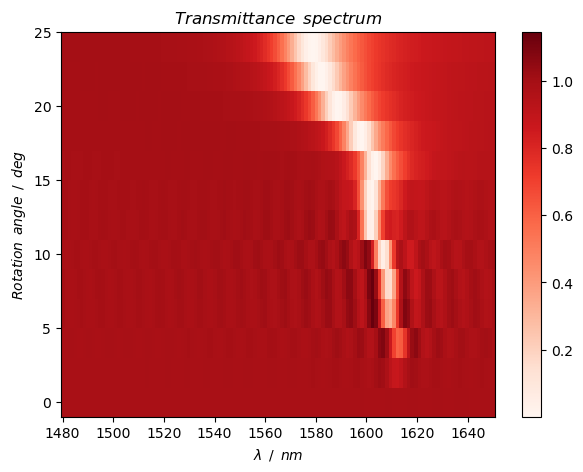

In [24]:
plt.figure(figsize=figsize_spectrum)
plt.pcolor(wavelength_vec * 1e9, np.rad2deg(rotation_angle_vec), t_mat, cmap=cmap_amp)
plt.colorbar()
plt.xlabel(r"$\lambda \enspace / \enspace nm$")
plt.ylabel(r"$Rotation \enspace angle \enspace / \enspace deg$")
plt.title(r"$Transmittance \enspace spectrum$")
plt.show()

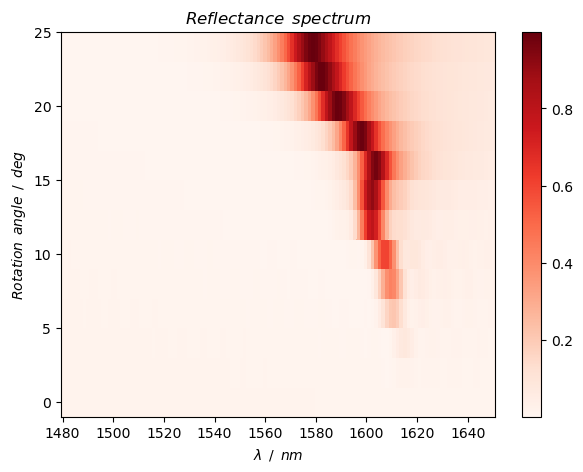

In [25]:
plt.figure(figsize=figsize_spectrum)
plt.pcolor(wavelength_vec * 1e9, np.rad2deg(rotation_angle_vec), r_mat, cmap=cmap_amp)
plt.colorbar()
plt.xlabel(r"$\lambda \enspace / \enspace nm$")
plt.ylabel(r"$Rotation \enspace angle \enspace / \enspace deg$")
plt.title(r"$Reflectance \enspace spectrum$")
plt.show()

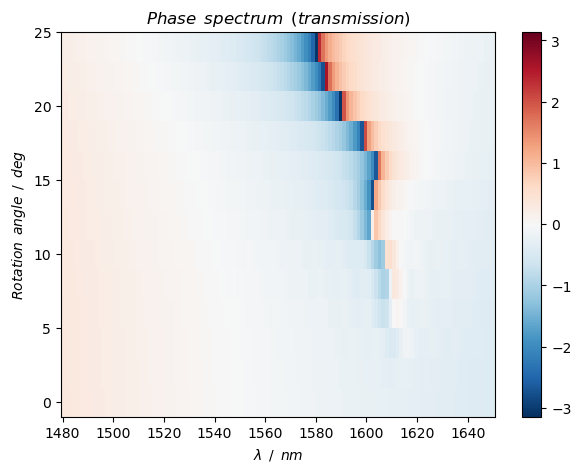

In [27]:
plt.figure(figsize=figsize_spectrum)
plt.pcolor(wavelength_vec * 1e9, np.rad2deg(rotation_angle_vec), phase_t_mat, cmap=cmap_ang, vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.xlabel(r"$\lambda \enspace / \enspace nm$")
plt.ylabel(r"$Rotation \enspace angle \enspace / \enspace deg$")
plt.title(r"$Phase \enspace spectrum \enspace (transmission)$")
plt.show()

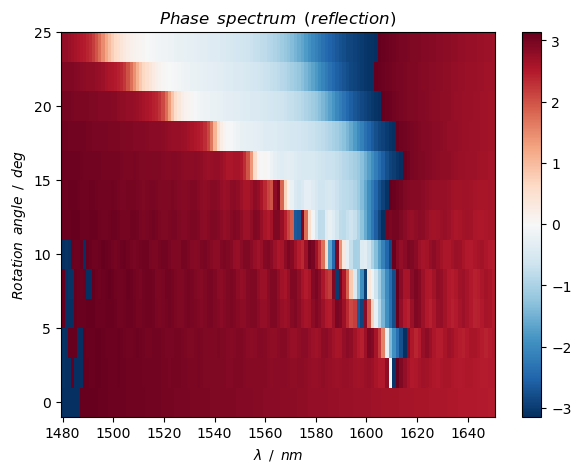

In [28]:
plt.figure(figsize=figsize_spectrum)
plt.pcolor(wavelength_vec * 1e9, np.rad2deg(rotation_angle_vec), phase_r_mat, cmap=cmap_ang, vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.xlabel(r"$\lambda \enspace / \enspace nm$")
plt.ylabel(r"$Rotation \enspace angle \enspace / \enspace deg$")
plt.title(r"$Phase \enspace spectrum \enspace (reflection)$")
plt.show()

### 2.4 Spectrum analysis for specific asymmetric structure and Fano fitting

#### 2.4.1 Spectrum analysis for specific asymmetric structure

Asymmetry parameter = 0.20791169081775934
Rotation angle = 12.00 deg
Minimum wavelength: 1581.35 nm, maximum wavelength: 1619.25 nm


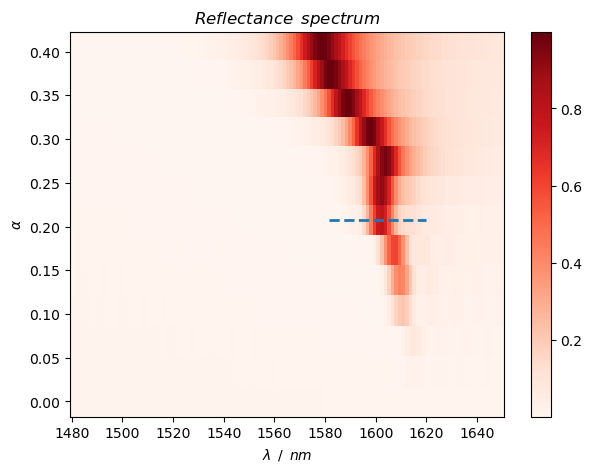

In [57]:
# spectrum line shape analysis for the specific structure
alpha_analysis = 0.2  # asymmetry parameter to be analyzed
alpha_analysis_idx = (np.abs(alpha_vec - alpha_analysis)).argmin()  # find the corresponding index
# range for spectrum to be analyzed
wavelength_analysis_min = 1580e-9  # [m]
wavelength_analysis_max = 1620e-9  # [m]
# find the index range for spectrum range to be analyzed (note that wavelength_vec is in descending order)
wavelength_analysis_min_idx = np.where(wavelength_vec >= wavelength_analysis_min)[0][-1]
wavelength_analysis_max_idx = np.where(wavelength_vec <= wavelength_analysis_max)[0][0]
wavelength_vec_analysis = wavelength_vec[wavelength_analysis_max_idx:wavelength_analysis_min_idx + 1]

# print and draw choose result
print("Asymmetry parameter = {}".format(alpha_vec[alpha_analysis_idx]))
print("Rotation angle = {:.2f} deg".format(np.rad2deg(rotation_angle_vec[alpha_analysis_idx])))
print("Minimum wavelength: {:.2f} nm, maximum wavelength: {:.2f} nm".format(
    wavelength_vec[wavelength_analysis_min_idx] * 1e9, wavelength_vec[wavelength_analysis_max_idx] * 1e9
))

plt.figure(figsize=figsize_spectrum)
plt.pcolor(wavelength_vec * 1e9, alpha_vec, r_mat, cmap=cmap_amp)
plt.colorbar()
plt.xlabel(r"$\lambda \enspace / \enspace nm$")
plt.ylabel(r"$\alpha$")
plt.title(r"$Reflectance \enspace spectrum$")
xmin = (wavelength_vec[wavelength_analysis_min_idx] - wavelength_min) / (wavelength_max - wavelength_min)
xmax = (wavelength_vec[wavelength_analysis_max_idx] - wavelength_min) / (wavelength_max - wavelength_min)
plt.axhline(alpha_vec[alpha_analysis_idx], xmin=xmin, xmax=xmax, linestyle="--", color="tab:blue", linewidth=2)
plt.show()

In [36]:
# obtain the target spectrum
omega_vec_analysis = c * 2 * np.pi / wavelength_vec_analysis
t_vec_analysis = t_mat[alpha_analysis_idx, wavelength_analysis_max_idx:wavelength_analysis_min_idx + 1]
r_vec_analysis = r_mat[alpha_analysis_idx, wavelength_analysis_max_idx:wavelength_analysis_min_idx + 1]

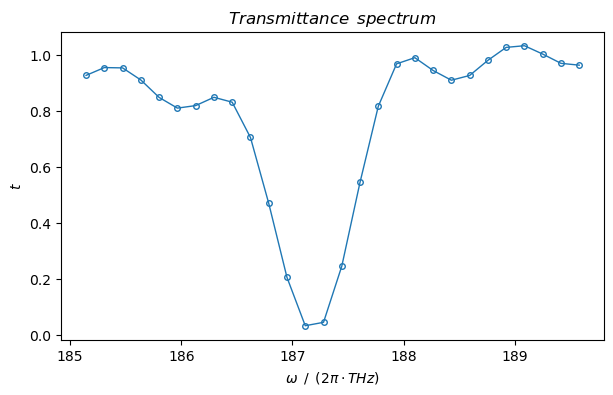

In [81]:
plt.figure(figsize=(7, 4))
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, t_vec_analysis, linestyle="-", linewidth=1, marker="o", markersize=4, markerfacecolor="none")
plt.xlabel(r"$\omega \enspace / \enspace (2\pi \cdot THz)$")
plt.ylabel(r"$t$")
plt.title(r"$Transmittance \enspace spectrum$")
plt.show()

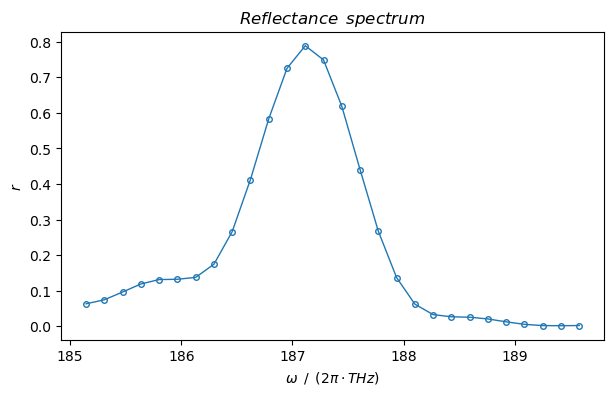

In [82]:
plt.figure(figsize=(7, 4))
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, r_vec_analysis, linestyle="-", linewidth=1, marker="o", markersize=4, markerfacecolor="none")
plt.xlabel(r"$\omega \enspace / \enspace (2\pi \cdot THz)$")
plt.ylabel(r"$r$")
plt.title(r"$Reflectance \enspace spectrum$")
plt.show()

#### 2.4.2 Fano fitting

In [60]:
i_vec_analysis = r_vec_analysis.copy()  # choose T/R spectrum to do Fano fitting

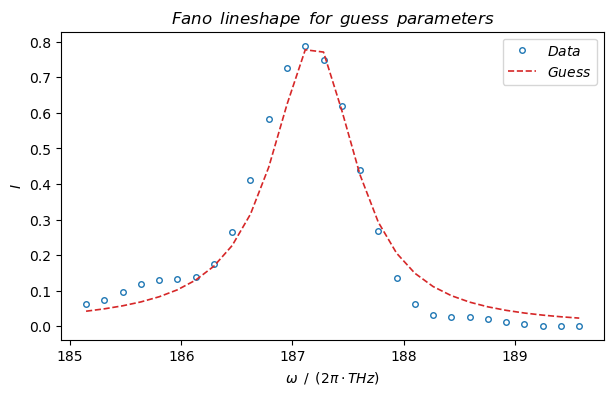

In [72]:
# initial guess for the Fano parameters
initial_guess = [
    187.2 * 1e12 * 2 * np.pi,  # omega_0 = 2 \pi * f_0 [rad Hz]
    -60.,  # q
    0.9 * 1e12 * 2 * np.pi,  # gamma = 2 \pi * \Delta f [rad Hz]
    0.8,  # i_0
    0.0  # i_bg
]
# define the bounds for the parameters
lower_bounds = [0.0, -np.inf, 0.0, 0.0, 0.0]
upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]  # set the upper bound of i_bg to a small value to ignore its influence

plt.figure(figsize=(7, 4))
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, i_vec_analysis, 
         linestyle="none", marker="o", markersize=4, markerfacecolor="none", label=r"$Data$")
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, fano(omega_vec_analysis, *initial_guess), 
         linestyle="--", linewidth=1.2, color="tab:red", label=r"$Guess$")
plt.xlabel(r"$\omega \enspace / \enspace (2\pi \cdot THz)$")
plt.ylabel(r"$I$")
plt.title(r"$Fano \enspace lineshape \enspace for \enspace guess \enspace parameters$")
plt.legend()
plt.show()

In [73]:
# perform the curve fitting (scipy: curve_fit)
popt, pcov = curve_fit(fano, omega_vec_analysis, i_vec_analysis, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
omega_0_fit, q_fit, gamma_fit, i_0_fit, i_bg_fit = popt

In [78]:
# calculate the Q factor
q_factor = omega_0_fit / gamma_fit

# obtain the fitting curve
i_vec_fit = fano(omega_vec_analysis, omega_0_fit, q_fit, gamma_fit, i_0_fit, i_bg_fit)

# calculate RMSE
residuals = i_vec_analysis - i_vec_fit
rmse = np.sqrt(np.mean(residuals**2))

In [79]:
# print fitting result
print("Fitted Fano parameters:\n omega_0: 2 pi * {:.4f} THz \n q: {:.8f} \n Gamma: 2 pi * {:.4f} THz \n I_0: {:8f} \n I_bg: {:8f}".format(
    omega_0_fit / (2 * np.pi) * 1e-12, 
    q_fit, 
    gamma_fit / (2 * np.pi) * 1e-12, i_0_fit, i_bg_fit
))

# print evaluation metrics
print("Fitting evaluation metrics: \n RMSE: {:.8f}".format(rmse))

# print Q factor
print("Q factor: {:.4f}".format(q_factor))

print("Resonance wavelength: {:.2f} nm".format(2 * np.pi * c / omega_0_fit * 1e9))

Fitted Fano parameters:
 omega_0: 2 pi * 187.2000 THz 
 q: -32.84849046 
 Gamma: 2 pi * 0.9000 THz 
 I_0: 0.834260 
 I_bg: 0.007470
Fitting evaluation metrics: 
 RMSE: 0.04644680
Q factor: 208.0000
Resonance wavelength: 1601.46 nm


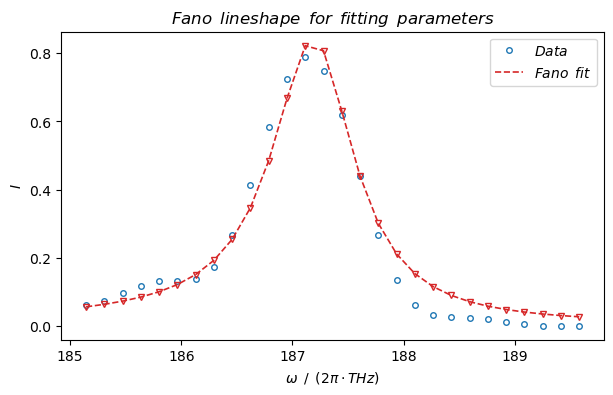

In [80]:
# draw fitting result
plt.figure(figsize=(7, 4))
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, i_vec_analysis, 
         linestyle="none", marker="o", markersize=4, markerfacecolor="none", label=r"$Data$")
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, i_vec_fit, 
         linestyle="none", color="tab:red", marker="v", markersize=4, markerfacecolor="none")
plt.plot(omega_vec_analysis * 1e-12 / 2 / np.pi, fano(omega_vec_analysis, omega_0_fit, q_fit, gamma_fit, i_0_fit, i_bg_fit), 
         linestyle="--", linewidth=1.2, color="tab:red", label=r"$Fano \enspace fit$")
plt.xlabel(r"$\omega \enspace / \enspace (2\pi \cdot THz)$")
plt.ylabel(r"$I$")
plt.title(r"$Fano \enspace lineshape \enspace for \enspace fitting \enspace parameters$")
plt.legend()
plt.show()

In [ ]:
# # close FDTD
# fdtd.close()